# Trending YouTube Video Statistics
### Data Exploration and Visualization With Python
***

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e1/Logo_of_YouTube_%282015-2017%29.svg'>

# Table of Contents

* [1. Importing dataset and data preprocessing](#importing_dataset_and_data_preprocessing) <br>
 * [1.1. Importing essential libraries](#importing_essential_libraries) <br>
 * [1.2. Importing datasets](#importing_datasets) <br>
 * [1.3. Let's summarize the datasets](#lets_summarize_the_dataset) <br>
 * [1.4. Data preprocessing and feature engineering](#data_preprocessing_and_feature_engineering) <br>
   * [1.4.1. Datetime format of Trending date and Publish time](#datetime_format_of_trending_date_and_publish_time) <br>
   * [1.4.2. Assignment of the film category](#assignment_of_the_film_category) <br>
   * [1.4.3. What about duplicates?](#what_about_duplicates) <br>
   * [1.4.4. Time to trend](#time_to_trend) <br>
<br>
* [2. Data Visualization](#data_visualization) <br>
 * [2.1. Top 10 trending videos](#top_trending_videos) <br>
 * [2.2. Top 50 trending creators](#top_trending_creators) <br>
 * [2.3. Late bloomers](#late_bloomers) <br>

## 1. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

### 1.1. Importing essential libraries
<a id="importing_essential_libraries"></a>

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

### 1.2. Importing dataset
<a id="importing_datasets"></a>

In [19]:
us_videos = pd.read_csv('../00_Datasets/YouTube/USvideos.csv')
us_videos_categories = pd.read_json('../00_Datasets/YouTube/US_category_id.json')

### 1.3. Let's summarize the dataset
<a id="lets_summarize_the_dataset"></a>

In [20]:
us_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


In [21]:
us_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20967 entries, 0 to 20966
Data columns (total 16 columns):
video_id                  20967 non-null object
trending_date             20967 non-null object
title                     20967 non-null object
channel_title             20967 non-null object
category_id               20967 non-null int64
publish_time              20967 non-null object
tags                      20967 non-null object
views                     20967 non-null int64
likes                     20967 non-null int64
dislikes                  20967 non-null int64
comment_count             20967 non-null int64
thumbnail_link            20967 non-null object
comments_disabled         20967 non-null bool
ratings_disabled          20967 non-null bool
video_error_or_removed    20967 non-null bool
description               20561 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 2.1+ MB


### 1.4. Data preprocessing and feature engineering
<a id="data_preprocessing_and_feature_engineering"></a>

<b>NOTE:</b> We immediately see, that in the first place we have to process the raw data loaded from the file. Firstly we will transform ```trending_date``` as well as ```publish_time``` from string to datetime format. This will allow us to easily perform arithmetic operations and compare these values. ```publish_time``` column will be divided into two separate ones ```publish_date``` and ```publish_time```. Next we will connect the films with the categories they belong to. Lastly we will create new feature ```time to trend``` representing the time (in days) between publication and the day when it became trending.

### 1.4.1. Datetime format of Trending date and Publish time
<a id="datetime_format_of_trending_date_and_publish_time"></a>

In [22]:
# Transforming Trending date column to datetime format
us_videos['trending_date'] = pd.to_datetime(us_videos['trending_date'], format='%y.%d.%m').dt.date

# Transforming Trending date column to datetime format and splitting into two separate ones
publish_time = pd.to_datetime(us_videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
us_videos['publish_date'] = publish_time.dt.date
us_videos['publish_time'] = publish_time.dt.time

In [23]:
us_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_date
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017-11-13


### 1.4.2. Assignment of the film category
<a id="assignment_of_the_film_category"></a>

In [24]:
# We'll use a very nice python featur - dictionary comprehension, to extract most important data from US_category_id.json
categories = {category['id']: category['snippet']['title'] for category in us_videos_categories['items']}

# Now we will create new column that will represent name of category
us_videos.insert(4, 'category', us_videos['category_id'].astype(str).map(categories))

### 1.4.3. What about duplicates?
<a id="what_about_duplicates"></a>

<b>NOTE:</b> Because many of the films have been trending you several times, we will create a separate datasets in which we will get rid of repetitions. Still, we leave the original dataset, because there is a lot of interesting information in it.

In [27]:
us_videos_last = us_videos.drop_duplicates(subset=['video_id'], keep='last', inplace=False)
us_videos_first = us_videos.drop_duplicates(subset=['video_id'], keep='first', inplace=False)

In [28]:
print("us_videos dataset contains {} videos".format(us_videos.shape[0]))
print("us_videos_first dataset contains {} videos".format(us_videos_first.shape[0]))
print("us_videos_last dataset contains {} videos".format(us_videos_last.shape[0]))

us_videos dataset contains 20967 videos
us_videos_first dataset contains 4416 videos
us_videos_last dataset contains 4416 videos


### 1.4.4. Time to trend
<a id="time_to_trend"></a>

In [29]:
us_videos_first["time_to_trend"] = (us_videos_first.trending_date - us_videos_first.publish_date) / np.timedelta64(1, 'D')

/home/afghan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## 2. Data Visualization
<a id="data_visualization"></a>

### 2.1. Top 10 trending videos
<a id="top_trending_videos"></a>

In [31]:
from IPython.display import HTML, display

# We choose the 10 most trending videos
selected_columns = ['title', 'channel_title', 'thumbnail_link', 'publish_date', 'category']

most_frequent = us_videos.groupby(selected_columns)['video_id'].agg(
    {"code_count": len}).sort_values(
    "code_count", ascending=False
).head(10).reset_index()

# Construction of HTML table with miniature photos assigned to the most popular movies
table_content = ''
max_title_length = 50

for date, row in most_frequent.T.iteritems():
    HTML_row = '<tr>'
    HTML_row += '<td><img src="' + str(row[2]) + '"style="width:100px;height:100px;"></td>'
    HTML_row += '<td>' + str(row[1]) + '</td>'
    HTML_row += '<td>' + str(row[0])  + '</td>'
    HTML_row += '<td>' + str(row[4]) + '</td>'
    HTML_row += '<td>' + str(row[3]) + '</td>'
    
    table_content += HTML_row + '</tr>'

display(HTML(
    '<table><tr><th>Photo</th><th>Channel Name</th><th style="width:250px;">Title</th><th>Category</th><th>Publish Date</th></tr>{}</table>'.format(table_content))
)

/home/afghan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



Photo,Channel Name,Title,Category,Publish Date
,Cardi B,Cardi B - Bartier Cardi (feat. 21 Savage) [Official Audio],People & Blogs,2017-12-22
,MigosVEVO,Migos - Stir Fry (Audio),Music,2017-12-20
,Ben Pluimer,Lucky the iPhone singing cockatiel is OVER it!,Film & Animation,2017-12-20
,Universal Pictures,Mamma Mia! Here We Go Again - Trailer,Entertainment,2017-12-21
,Atlantic Records,Kesha - This Is Me (from The Greatest Showman Soundtrack) [Official Audio],Music,2017-12-22
,Saturday Night Live,Cut for Time: Hallmark Channel Christmas Promo (James Franco) - SNL,Entertainment,2017-12-21
,SZAVEVO,SZA - The Weekend (Official Video),Music,2017-12-22
,Doug Ellison,"SpaceX Iridium 4 Launch from Alhambra, CA",Science & Technology,2017-12-23
,Macklemore LLC,MACKLEMORE FEAT DAVE B & TRAVIS THOMPSON - CORNER STORE (Official Music Video),Music,2017-12-21
,KatyPerryVEVO,Katy Perry - Hey Hey Hey (Official),Music,2017-12-20


### 2.2. Top 50 trending creators
<a id="top_trending_creators"></a>

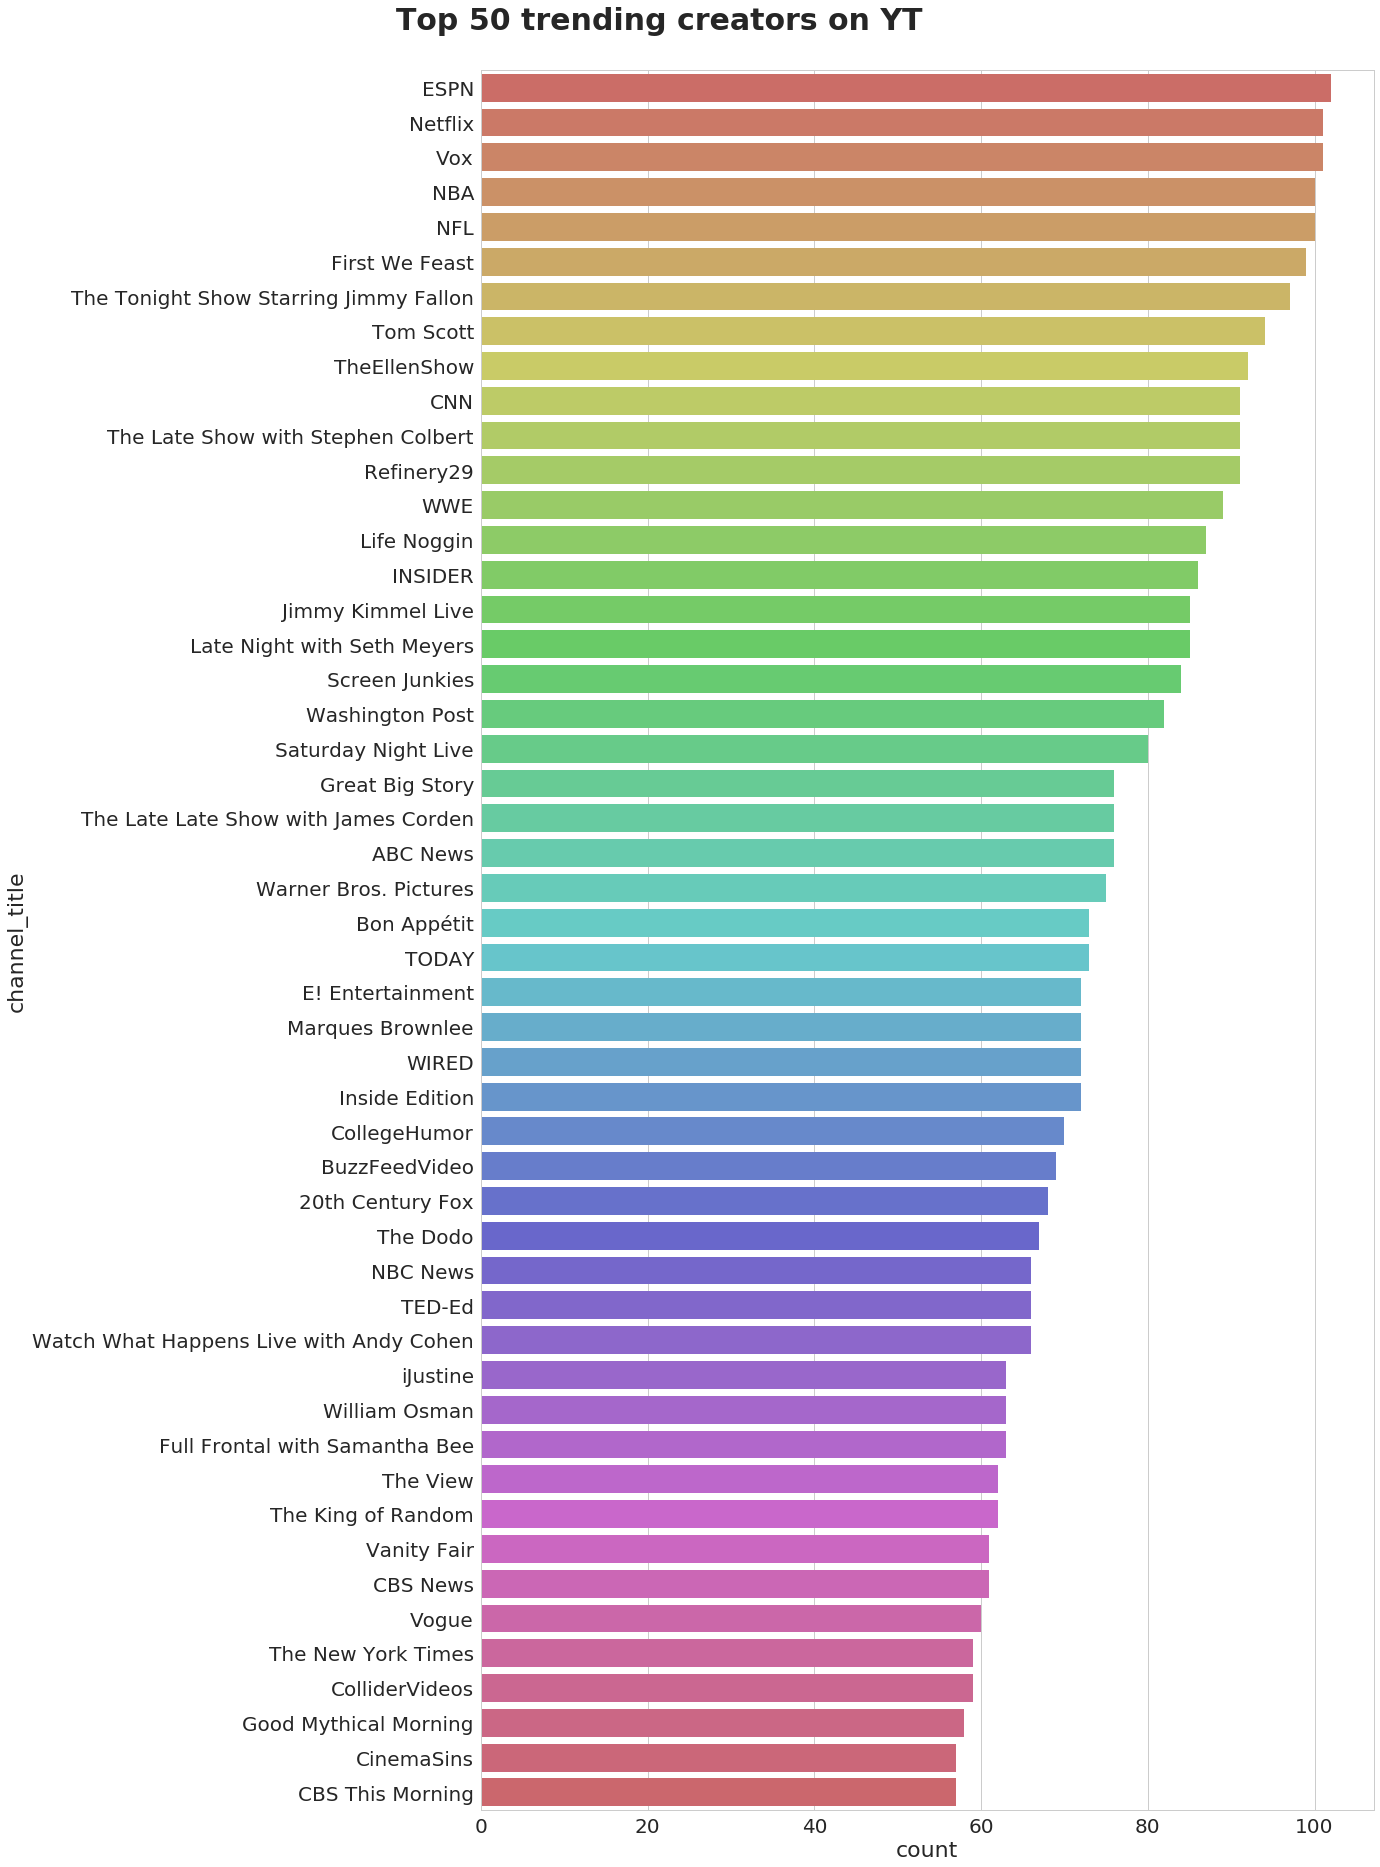

In [32]:
plt.figure(figsize=(16,32))
sns.set(font_scale=2)
sns.set_style("whitegrid")
plt.title('Top 50 trending creators on YT', fontsize=30, fontweight='bold', y=1.02, x = 0.2)
sns.countplot(y="channel_title", data=us_videos, palette="hls", order=us_videos.channel_title.value_counts().iloc[:50].index);
plt.show()

### 2.3. Late bloomers
<a id="late_bloomers"></a>
[Top 10 videos that waited the longest before it became trending]

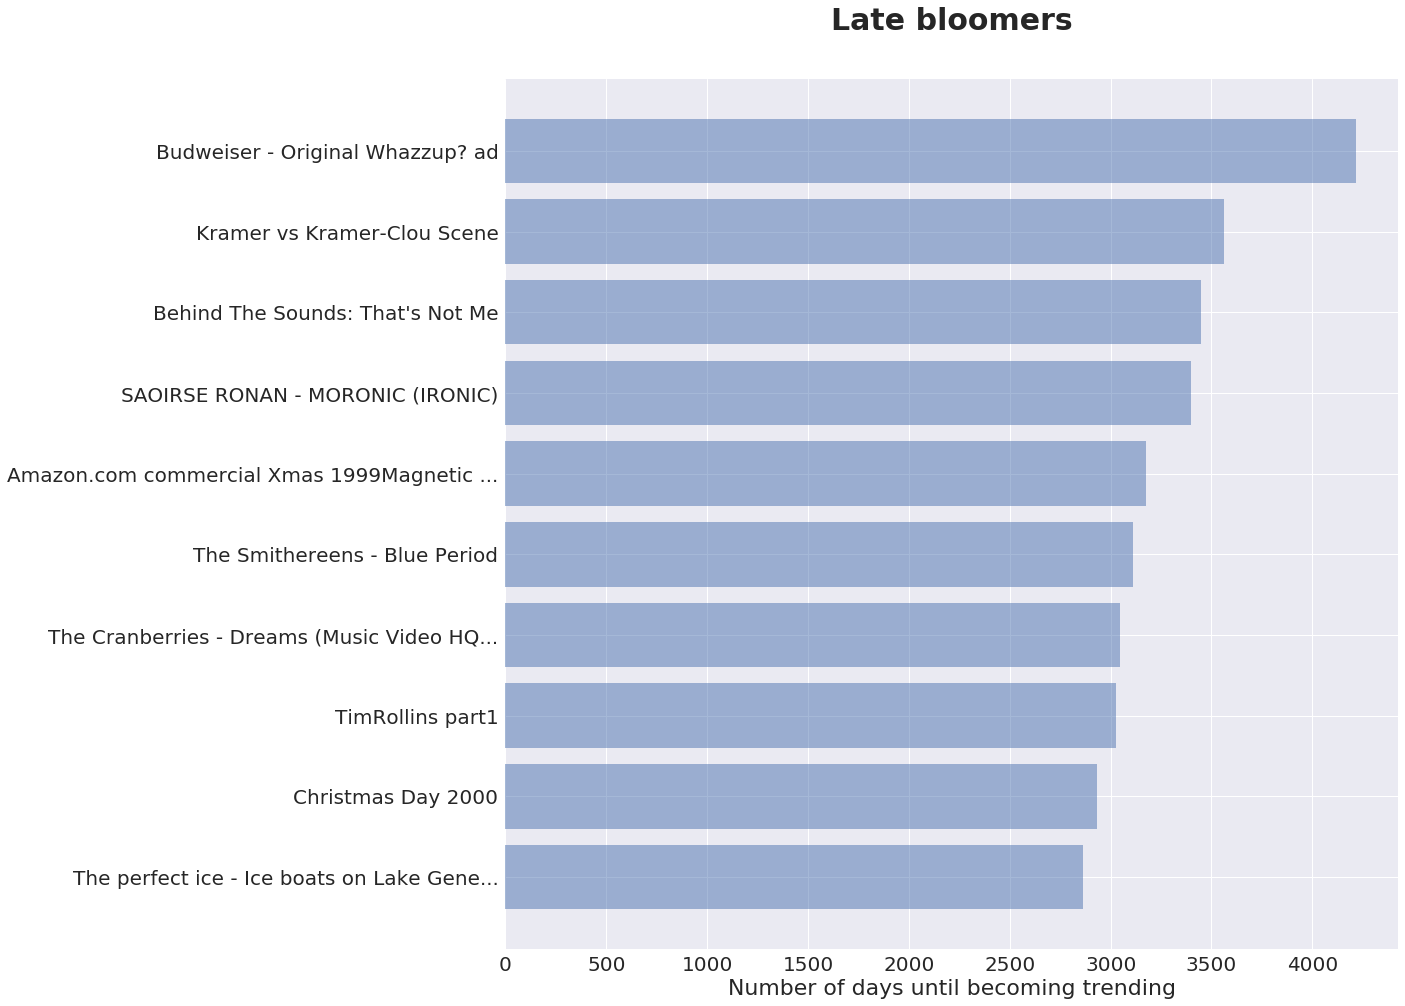

In [81]:
max_title_length = 40
late_bloomers = us_videos_first.sort_values(["time_to_trend"], ascending=False).head(10)
late_bloomers_title = [(x if len(x) <= max_title_length else x[:max_title_length] + "...") for x in late_bloomers.title.values]
late_bloomers_days = late_bloomers.time_to_trend.values

plt.figure(figsize=(16,16))
plt.title('Late bloomers', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('Number of days until becoming trending')

max_value = late_bloomers_days.max()
objects = late_bloomers_title[::-1]
y_pos = np.arange(len(objects))
performance = late_bloomers_days[::-1]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)


plt.show()

# To be continued... :)